In [2]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import chi2_contingency
from cellrank.estimators import GPCCA
import matplotlib.pyplot as plt
import scanpy.external as sce
import scrublet as scr
#import pyranges as pr
import seaborn as sns
import cellrank as cr
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import collections
import matplotlib
#import pyBigWig
#import networkx
#import pyscenic
import requests
#import network
#import fsspec
import anndata
#import igraph
import scvi
import h5py
import desc 
import umap
import sys
import re
import os


%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)
plt.rcParams.update({'font.size': 10})

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [7]:
from scipy.cluster.hierarchy import linkage

In [2]:
def process_loom_file(file_path):
    """
    Reads and processes a loom file, returning the sample ID and the processed AnnData object.

    Parameters:
    - file_path (str): Path to the loom file.

    Returns:
    - sample_id (str): The sample ID extracted from the file name.
    - adata (AnnData): The processed AnnData object.
    """
    # Read in the loom file
    adata = scv.read(file_path, cache=True)
    # Ensure variable names are unique
    adata.var_names_make_unique()
    # Filtering as done in Seurat
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    # Compute mitochondrial percentage and other QC metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # Extract sample ID from file path
    sample_id = extract_sample_id(file_path)
    return sample_id, adata

def extract_sample_id(file_path):
    """
    Extracts the sample ID from the given file path.

    Parameters:
    - file_path (str): The path to the file.

    Returns:
    - sample_id (str): The sample ID extracted from the file name.
    """
    # Get the base name of the file (e.g., 'OS152.loom')
    file_name = os.path.basename(file_path)
    # Remove the file extension (e.g., '.loom')
    sample_id = os.path.splitext(file_name)[0]
    return sample_id

In [3]:
# List of your loom file paths
file_paths = [
    '/Users/brendamelano/Desktop/10xver7/OS152/OS152.loom',
    '/Users/brendamelano/Desktop/10xver7/OS384/OS384.loom',
    '/Users/brendamelano/Desktop/os_data/OS742/OS742.loom'
]

# Dictionary to store your processed AnnData objects
adata_dict = {}

for file_path in file_paths:
    sample_id, adata = process_loom_file(file_path)
    # Store the processed AnnData object with the sample ID as the key
    adata_dict[sample_id] = adata

... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS152-OS152.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS384-OS384.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


... reading from cache file cache/Users-brendamelano-Desktop-os_data-OS742-OS742.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [4]:
# Accessing the processed data
adata_152 = adata_dict['OS152']
adata_384 = adata_dict['OS384']
adata_742 = adata_dict['OS742']

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

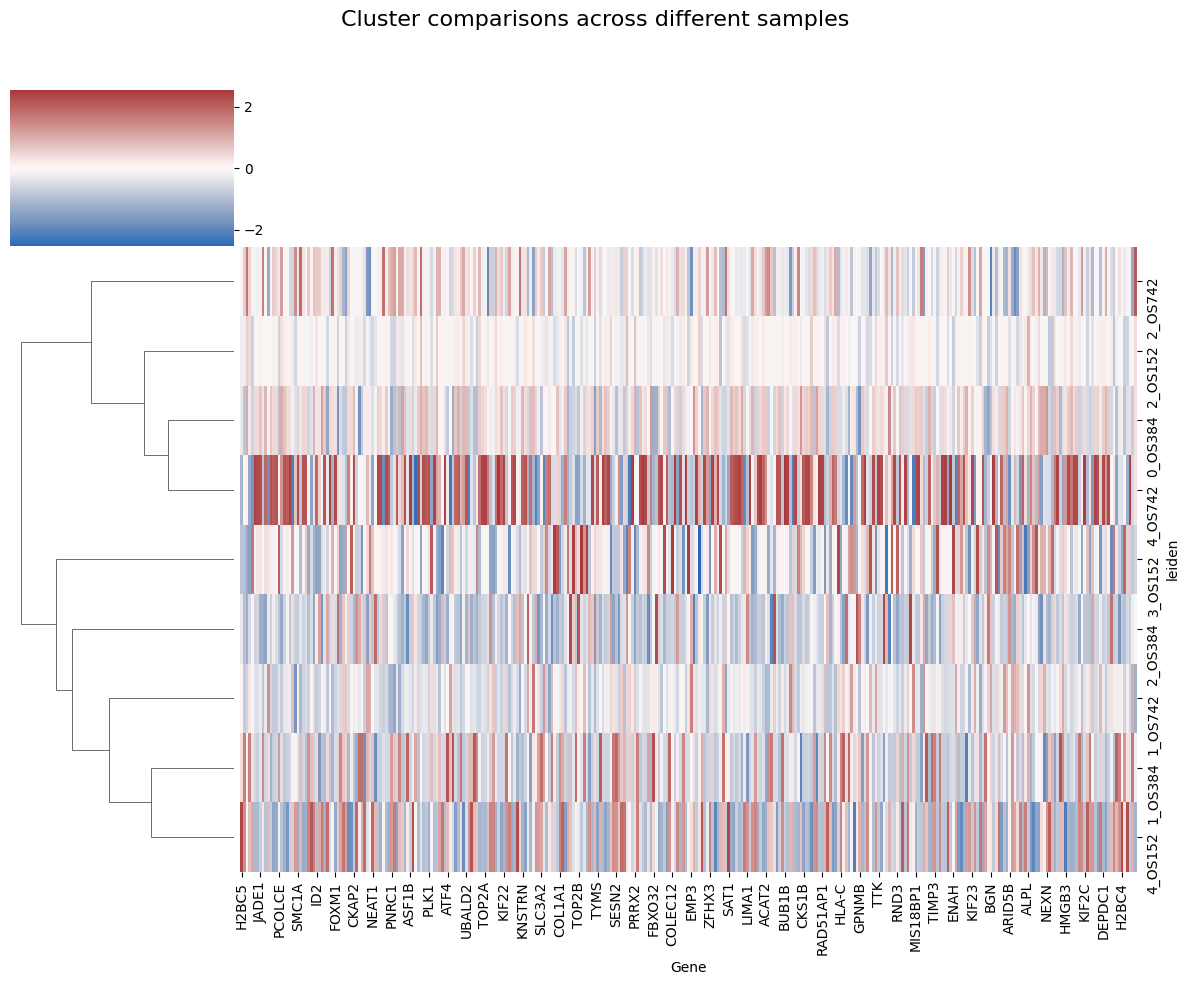

In [12]:

# Initialize lists to store data
adata_list = []
top_genes_all_samples = []

# List of sample names
sample_names = ['OS152', 'OS384', 'OS742']

for sample in sample_names:
    # Step 1: Read in the AnnData file
    adata = sc.read(f"/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/{sample}/{sample}_adata_subtype_PCA.h5ad")
    
    # Step 2: Ensure 'leiden' is present and is categorical
    if 'leiden' not in adata.obs.columns:
        raise KeyError(f"'leiden' column not found in {sample}'s adata.obs")
    adata.obs['leiden'] = adata.obs['leiden'].astype('category')
    
    # Make cluster labels unique by combining 'leiden' and sample name
    adata.obs['leiden'] = adata.obs['leiden'].astype(str) + f'_{sample}'
    adata.obs['leiden'] = adata.obs['leiden'].astype('category')
    
    # Step 3: Find top markers per cluster (leiden) in this sample
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=300)
    
    # Step 4: Extract the top X genes per cluster
    top_genes = []
    rg_names = adata.uns['rank_genes_groups']['names']
    for cluster in adata.obs['leiden'].cat.categories:
        genes = rg_names[cluster][:300]
        top_genes.extend(genes)
    
    # Remove duplicates in the list of top genes for this sample
    top_genes = list(set(top_genes))
    
    # Append the top genes of this sample to the overall list
    top_genes_all_samples.extend(top_genes)
    
    # Add sample identifier
    adata.obs['sample'] = sample
    
    # Append the AnnData object to the list
    adata_list.append(adata)

# Step 5: Combine the top marker genes from all samples into a unique list
top_genes_all_samples = list(set(top_genes_all_samples))

# Step 6: Concatenate the AnnData objects
adata_combined = adata_list[0].concatenate(
    adata_list[1:], 
    batch_key='sample_batch', 
    index_unique=None
)

# Ensure that 'leiden' is categorical in the combined data
adata_combined.obs['leiden'] = adata_combined.obs['leiden'].astype('category')

# Step 7: Refilter the markers based on whether they are in the dataset
existing_genes = [gene for gene in top_genes_all_samples if gene in adata_combined.var_names]

# Inform the user about any genes that are not found
missing_genes = set(top_genes_all_samples) - set(existing_genes)
if missing_genes:
    print(f"The following genes were not found in the combined data and will be skipped: {missing_genes}")

# Proceed with the existing genes
adata_markers = adata_combined[:, existing_genes]

# Compute the mean expression per cluster
cluster_means = adata_markers.to_df().groupby(adata_markers.obs['leiden']).mean()

# Step 9: Normalize the data for better visualization (z-score normalization)
# Apply z-score normalization across genes (columns)
cluster_means_zscore = cluster_means.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Step 10: Optional - Aggregate clusters that are transcriptionally similar
# Perform hierarchical clustering on clusters
linkage_matrix = linkage(cluster_means_zscore, method='average', metric='correlation')

# Step 11: Create a heatmap using seaborn's clustermap
g = sns.clustermap(
    cluster_means_zscore, 
    row_linkage=linkage_matrix, 
    col_cluster=False, 
    cmap='vlag', 
    figsize=(12, 10)
)

# Add a title to the heatmap
g.fig.suptitle('Cluster comparisons across different samples', fontsize=16)

# Adjust the position of the title if needed
plt.subplots_adjust(top=0.9)  # Adjust the top margin to make room for the title

# Step 12: Save the heatmap as an SVG file
g.savefig('/Users/brendamelano/Desktop/Combined_Heatmap_TopMarkers.svg', format='svg', dpi=300)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be i

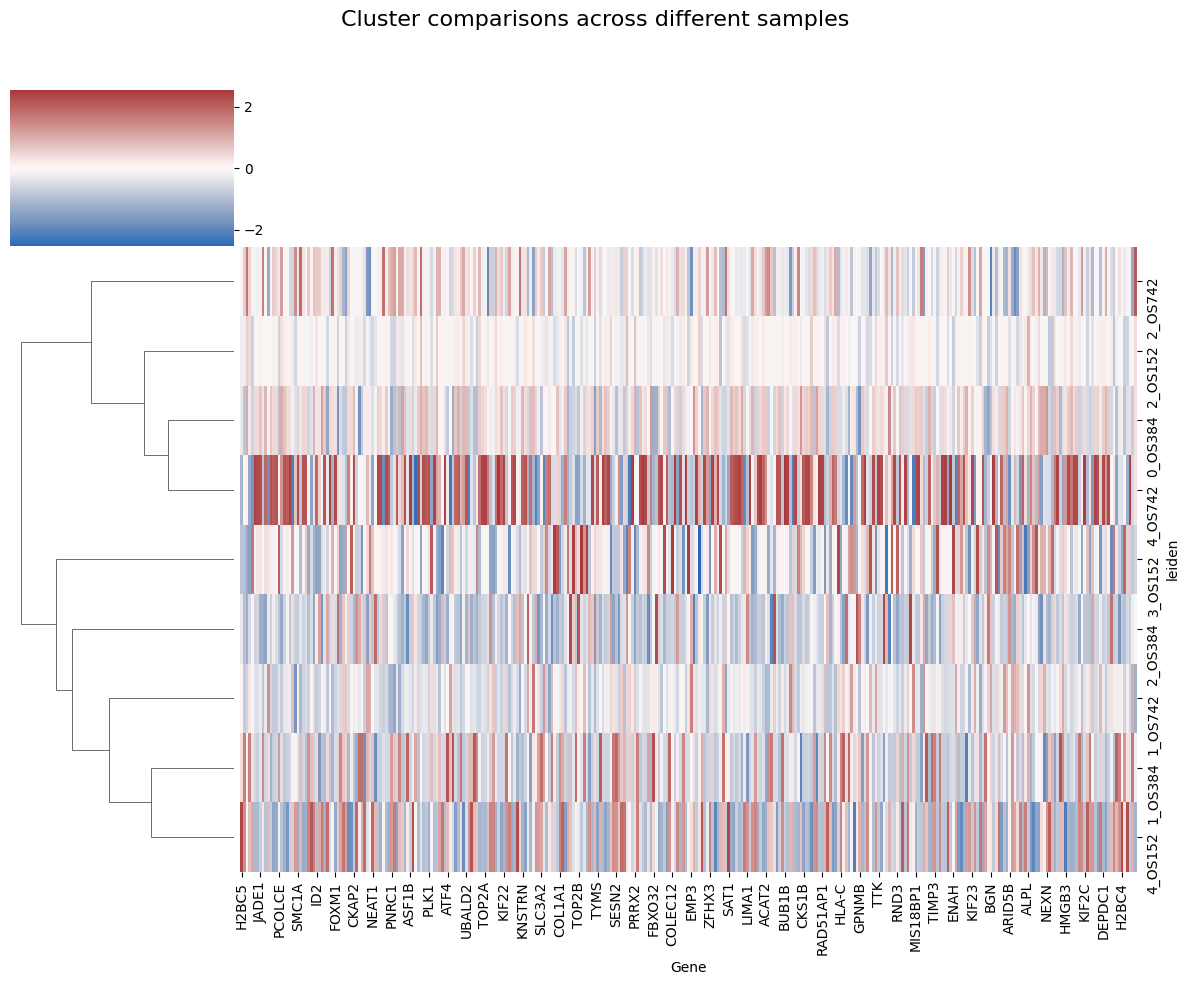

In [22]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
import scipy.sparse as sp  # Import scipy.sparse as sp

# Step 1: Read in the AnnData files and process them
adata_list = []
top_genes_all_samples = []
sample_names = ['OS152', 'OS384', 'OS742']

for sample in sample_names:
    # Read in the AnnData file
    adata = sc.read(f"/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/{sample}/{sample}_adata_subtype_PCA.h5ad")
    
    # Ensure 'leiden' is present and is categorical
    if 'leiden' not in adata.obs.columns:
        raise KeyError(f"'leiden' column not found in {sample}'s adata.obs")
    adata.obs['leiden'] = adata.obs['leiden'].astype('category')
    
    # Make cluster labels unique by combining 'leiden' and sample name
    adata.obs['leiden'] = adata.obs['leiden'].astype(str) + f'_{sample}'
    adata.obs['leiden'] = adata.obs['leiden'].astype('category')
    
    # Find top markers per cluster (leiden) in this sample
    # Since you want to identify markers prior to aggregation, we keep this step
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=300)
    
    # Extract the top X genes per cluster
    top_genes = []
    rg_names = adata.uns['rank_genes_groups']['names']
    for cluster in adata.obs['leiden'].cat.categories:
        genes = rg_names[cluster][:300]
        top_genes.extend(genes)
    
    # Remove duplicates in the list of top genes for this sample
    top_genes = list(set(top_genes))
    
    # Append the top genes of this sample to the overall list
    top_genes_all_samples.extend(top_genes)
    
    # Add sample identifier
    adata.obs['sample'] = sample
    
    # Append the AnnData object to the list
    adata_list.append(adata)

# Step 2: Combine the top marker genes from all samples into a unique list
top_genes_all_samples = list(set(top_genes_all_samples))

# Step 3: Concatenate the AnnData objects using join='outer' to include all genes
adata_combined = sc.AnnData.concatenate(
    *adata_list, batch_key='sample_batch', index_unique=None, join='outer'
)

# Ensure that 'leiden' is categorical in the combined data
adata_combined.obs['leiden'] = adata_combined.obs['leiden'].astype('category')

# Step 4: Remove genes with NaN values
# Check if adata_combined.X is sparse
if sp.issparse(adata_combined.X):
    X_dense = adata_combined.X.toarray()
else:
    X_dense = adata_combined.X

# Identify genes with any NaN values across all cells
genes_with_nan = np.isnan(X_dense).any(axis=0)

print(f"Number of genes before removing NaNs: {adata_combined.n_vars}")
print(f"Number of genes with NaN values: {np.sum(genes_with_nan)}")

# Remove genes with NaN values
adata_combined = adata_combined[:, ~genes_with_nan]
print(f"Number of genes after removing NaNs: {adata_combined.n_vars}")

# Step 5: Refilter the markers based on whether they are in the dataset
existing_genes = [gene for gene in top_genes_all_samples if gene in adata_combined.var_names]

# Inform the user about any genes that are not found
missing_genes = set(top_genes_all_samples) - set(existing_genes)
if missing_genes:
    print(f"The following genes were not found in the combined data and will be skipped: {missing_genes}")

# Proceed with the existing genes
adata_markers = adata_combined[:, existing_genes]

# Compute the mean expression per cluster
cluster_means = adata_markers.to_df().groupby(adata_markers.obs['leiden']).mean()

# Normalize the data for better visualization (z-score normalization)
# Remove genes with zero variance to avoid division by zero
cluster_means = cluster_means.loc[:, cluster_means.std() > 0]
cluster_means_zscore = cluster_means.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# Perform hierarchical clustering on clusters
linkage_matrix = linkage(cluster_means_zscore, method='average', metric='correlation')

# Create a heatmap using seaborn's clustermap
g = sns.clustermap(
    cluster_means_zscore,
    row_linkage=linkage_matrix,
    col_cluster=False,
    cmap='vlag',
    figsize=(12, 10)
)

# Add a title to the heatmap
g.fig.suptitle('Cluster comparisons across different samples', fontsize=16)

# Adjust the position of the title if needed
plt.subplots_adjust(top=0.9)  # Adjust the top margin to make room for the title

# Save the heatmap as an SVG file
g.savefig('/Users/brendamelano/Desktop/Combined_Heatmap_TopMarkers.svg', format='svg', dpi=300)
plt.show()

cluster_correlation = cluster_means.T.corr(method='pearson')
sns.clustermap(cluster_correlation, cmap='coolwarm', figsize=(12, 10))
plt.title('Correlation of Cluster Mean Expressions')
plt.show()


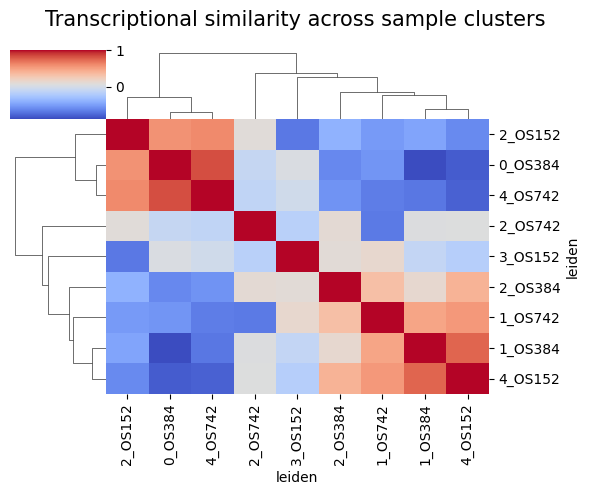

In [26]:

# Compute the mean expression per cluster (assuming adata_markers is defined)
cluster_means = adata_markers.to_df().groupby(adata_markers.obs['leiden']).mean()

# Proceed with your analysis...

# Calculate the correlation matrix of cluster mean expressions
cluster_correlation = cluster_means.T.corr(method='pearson')

# Create a clustermap to visualize the correlations
g = sns.clustermap(cluster_correlation, cmap='coolwarm', figsize=(6, 5))

# Add the title to the figure
g.fig.suptitle('Transcriptional similarity across sample clusters', fontsize=15)

# Adjust the position of the title if necessary
plt.subplots_adjust(top=0.9)

# Save the figure to the Desktop
desktop_path = os.path.expanduser('~/Desktop')
figure_path = os.path.join(desktop_path, 'Cluster_Transcriptional_Similarity.svg')
g.savefig(figure_path, format='svg', dpi=300)

# Display the plot
plt.show()
